# NLP Classifer: Twitter Sentiment on Apple and Google Products (Phase 4 Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time: 05.11.2023
* Instructor name: Morgan Jones
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:



This project aims to classify tweets from Twitter as containing positive, negative, or neutral sentiment about Apple or Google products.

## Overview and Business Understanding/Questions



My stakeholder is Google, who wishes to classify Twitter sentiment about both their own products as well as Apple products. 

These sentiments offer informal reviews of Google and Apple products, which can better help Google with future product development by gauging the failures and success of their own products and a major competitor's products. 

How can we categorize tweets as positive or negative?  

What kind of terms and hashtags are more likely to surround or embody positive or negative sentiment?

## Data Source and Exploration



This data comes from Data World at the following site: https://data.world/crowdflower/brands-and-product-emotions
Tweets regarding Google and Apple product were collected and contributors evaluated the tweets as containing positive, negative, or neutral content.

All features in the dataset were used. These were:

tweet_text

emotion_in_tweet_is_directed_at

is_there_an_emotion_directed_at_a_brand_or_product

There was some sort of error in the downloaded file that prevented accurate formatting.  I used Excel as an intermediary to import, edit, and then export the csv file again to fix the formatting issue. 

## Importing, Previewing, and Cleaning the Data




In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

In [2]:
#Read the data and set variable
df = pd.read_csv('tweets.csv')

#Previw data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,NaN
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,NaN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,NaN,NaN


It seems that additional columns were created in my editing of the file's formatting.  These Unnamed columns are superfluous, so I will remove them. 

The main features are also a little wordy. Out of convenience, I'm going to simplify these column names. 

In [3]:
#Drop unnecessary columns
df = df.drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)

#Rename features for convenience
df = df.rename(columns={'tweet_text': 'tweets', 
                        'emotion_in_tweet_is_directed_at': 'products', 
                        'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})

In [4]:
#View data
df.head()

,tweets,products,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Great!  The excess columns have been removed and the main features have been simplified.

In [5]:
#Check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweets    9261 non-null   object
 1   products  3306 non-null   object
 2   emotion   9081 non-null   object
dtypes: object(3)
memory usage: 217.2+ KB


It looks like we're missing quite a few values for the products column, and 180 values for emotion.  For the purposes of this classifer model, it may not be necessary to have all rows contain product information, so I will leave that for now.  However, the emotion class is essential, so let's take a look at what's happening there. 

In [6]:
#Preview emotion values
df.emotion.value_counts()

No emotion toward brand or product      5374
Positive emotion                        2976
Negative emotion                         570
I can't tell                             156
 USA                                       1
 Andro... {link} #sxsw #music #news"       1
 Texas                                     1
 Android                                   1
iPad                                       1
Name: emotion, dtype: int64

It seems that there are a few entries that have been mislabeled, perhaps shifted into an inappropriate column.  Since there are so few of these in comparison with the rest of the data, I am simply going to delete these mislabeled rows.

There are also 156 containing the string "I can't tell."  This will probably not be useful for our purposes, so I'm going to go ahead and delete any row that contains these uninformative values in the emotion column. 

In [7]:
#Remove outlying values
index_names = df[(df['emotion'] != 'No emotion toward brand or product') &
                (df['emotion'] != 'Positive emotion') &
                (df['emotion'] != 'Negative emotion')].index
df.drop(index_names, inplace = True)

In [8]:
#Confirm removal of outliers
df.emotion.value_counts()

No emotion toward brand or product    5374
Positive emotion                      2976
Negative emotion                       570
Name: emotion, dtype: int64

Great, so now our three classes make sense and all null or useless values have been removed. 
There are significantly more tweets with no emotion than with positive or negative emotion. There are very few negative emotion tweets in the dataset, so my expectation is that this model will not be able to classify negative tweets as effectively. I'm going to visualize the distribution of these classes to see the difference more clearly.

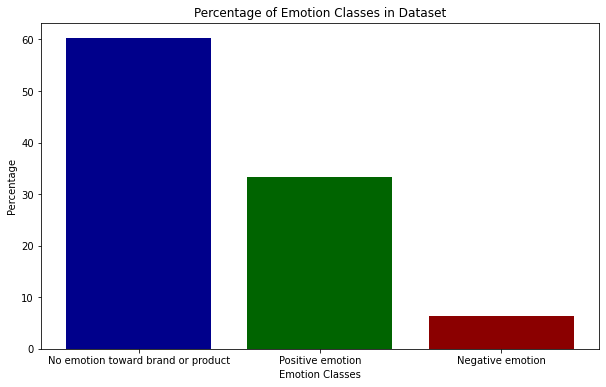

In [9]:
# Count the occurrences of each emotion class
class_counts = df['emotion'].value_counts()

# Calculate percentage
total = sum(class_counts.values)
percentages = [(value/total)*100 for value in class_counts.values]

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['darkblue', 'darkgreen', 'darkred']
ax.bar(class_counts.index, percentages, color=colors)

# Set axis labels and title
ax.set_xlabel('Emotion Classes')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Emotion Classes in Dataset')

# Display the plot
plt.show()

I'm also going to plot a stacked bar graph in case this makes the distribution clearer for the reader.

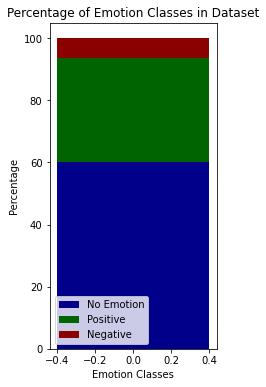

In [10]:
# Count the occurrences of each emotion class
class_counts = df['emotion'].value_counts()

# Calculate percentage
total = sum(class_counts.values)
percentages = [(value/total)*100 for value in class_counts.values]

# Create bar chart with stacked bars
fig, ax = plt.subplots(figsize=(3, 6))
ax.bar(0, percentages[0], label='No Emotion', color='darkblue')
ax.bar(0, percentages[1], bottom=percentages[0], label='Positive', color='darkgreen')
ax.bar(0, percentages[2], bottom=sum(percentages[:2]), label='Negative', color='darkred')

# Set axis labels and title
ax.set_xlabel('Emotion Classes')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Emotion Classes in Dataset')

# Add legend and display the plot
ax.legend()
plt.show()

This confirms how low the distribution is for negative tweets, especially.  We will see how the model fares with so few negative examples.

In [11]:
#Preview data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8920 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweets    8920 non-null   object
 1   products  3280 non-null   object
 2   emotion   8920 non-null   object
dtypes: object(3)
memory usage: 278.8+ KB


It still looks like over half of the rows do not have product information, but I will leave it for now in case this is somehow helpful for the classifier.  I am curious as to the values in this products column. Recall originally this column was labeled as emotion_in_tweet_is_directed_at.

In [12]:
#Preview product values
df.products.value_counts()

iPad                               941
Apple                              659
iPad or iPhone App                 469
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: products, dtype: int64

The labels are subdivided within the larger categories of Apple or Google.  While I am not sure the distinction between "iPad," "iPad or iPhone App," and "iPhone," it is possible that the model will be better able to evaluate an emotion based on these subcategories (perhaps a label of 'iPhone' is more likely to be associated with a negative emotion, for example), so I will leave these as they are for now. Again, it may be easier to simply remove this column in the future. 

## Manipulating the Data

Below I standardize the tweets so they are all lowercase

In [13]:
#Standardize tweets to lowercase
df.tweets = df.tweets.str.lower()
df.head()

,tweets,products,emotion
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion


I now need to tokenize the tweets.

In [14]:
#Token pattern
basic_token_pattern = r"(?u)\b\w\w+\b"

#Tokenizer variable
tokenizer = RegexpTokenizer(basic_token_pattern)

#Apply tokenizer
df["tweets_tokenized"] = df["tweets"].apply(tokenizer.tokenize)

#Preview change
df.head()

,tweets,products,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


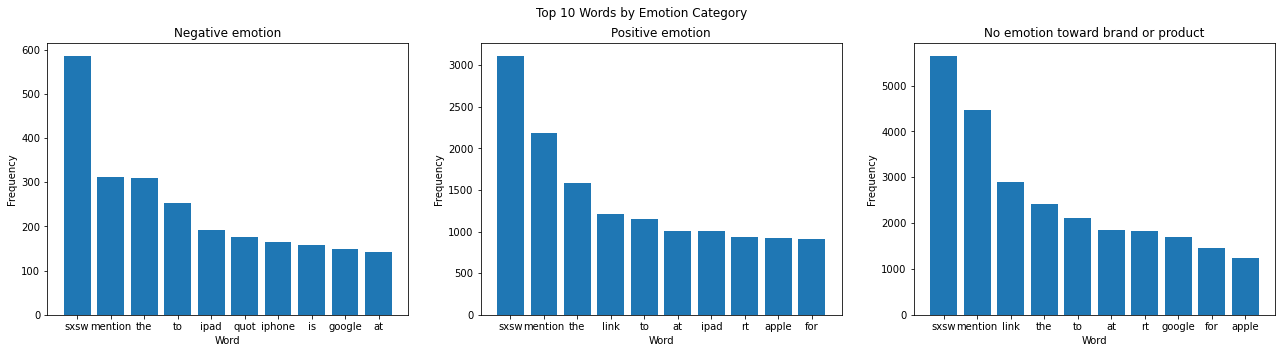

In [15]:
#Function to plot Top 10 tokens by emotion
def plot_frequency_by_emotion(dataframe):
    # Tokenize words in the 'tweets_tokenized' column and creating a list of all tokens
    all_tokens = [token for tweet in df['tweets_tokenized'] for token in tweet]

    # Calculate frequency distribution for all tokens
    all_tokens_freq = FreqDist(all_tokens)

    # Set up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22,5))

    # Plot frequency distribution for each category
    for index, emotion in enumerate(df['emotion'].unique()):
        # Filter dataframe by emotion category and tokenizing words
        category_tokens = [token for tweet in df[df['emotion'] == emotion]['tweets_tokenized'] for token in tweet]

        # Calculate frequency distribution for this category
        category_tokens_freq = FreqDist(category_tokens)

        # Get top 10 most common tokens and their counts
        top_10_tokens = [token[0] for token in category_tokens_freq.most_common(10)]
        top_10_counts = [token[1] for token in category_tokens_freq.most_common(10)]

        # Plot bar chart of top 10 tokens and their counts
        ax = axes[index]
        ax.bar(top_10_tokens, top_10_counts)
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    plt.suptitle('Top 10 Words by Emotion Category')
    plt.show()

plot_frequency_by_emotion(df)


Informative! It seems that these tweets were potentially collected during a South by Southwest conference.. There looks to be significant overlap in these top 10 terms and there are stopwords that I will eventually remove.  

###Build and Evaluate a Baseline Model

In [16]:
X = pd.DataFrame(data=df.tweets)
y = df.emotion

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])


In [18]:
# We should still have the same number of rows
assert X_train_vectorized.shape[0] == X_train.shape[0]

# The vectorized version should have 10 columns, since we set
# max_features=10
assert X_train_vectorized.shape[1] == 10

In [19]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.60364146, 0.60406447, 0.60406447, 0.6033637 , 0.6033637 ])

In [20]:
#Comparing the above cv with the class balance
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.603700
Positive emotion                      0.335342
Negative emotion                      0.060959
Name: emotion, dtype: float64

If we were to guess the plurality every time, "No emotion," we could expect a 60.37% accuracy.  So right now this model is actually a reduction in accuracy at an average of 60.36%.

Let's see if removing stopwords helps.

###Build a Second Model without Stopwords

In [21]:
#Download stopwords
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

In [22]:
#Function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [23]:
#Remove stopwords from tweets_tokenized
df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)
df.head()

,tweets,products,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


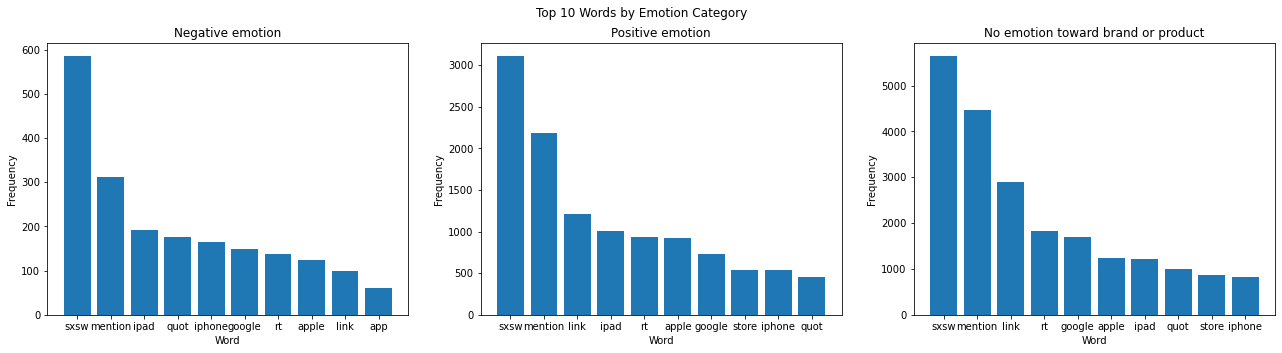

In [24]:
#Visualize token frequency by emotion without stopwords
plot_frequency_by_emotion(df)

So the stopwords have been removed, great!  There still seems to be significant overlap between the words in each category, for example the words sxsw, mention, ipad, apple, iphone, google, link, rt, and quot are found in all three, and 'store' is found in two out of the three.  Since these terms are so common among all three, they may not be particularly useful for the model to distiguish between these three categories.  Before iterating our next model, I will remove them.  

In [25]:
#Confirm length of stopword list
print("Original list length:", len(stopwords_list))

#Add new words
new_words = ['sxsw', 'mention', 'ipad', 'quot', 'iphone', 'google', 'rt', 'apple', 'link', 'quot', 'store']
stopwords_list.extend(new_words)

#Verify new length of stopword list
print("List length after adding 'for':", len(stopwords_list))

Original list length: 179
List length after adding 'for': 190


In [26]:
#Apply stopwords removal
df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)

Let's update the dataframe with the appended list and see the frequency distribution.

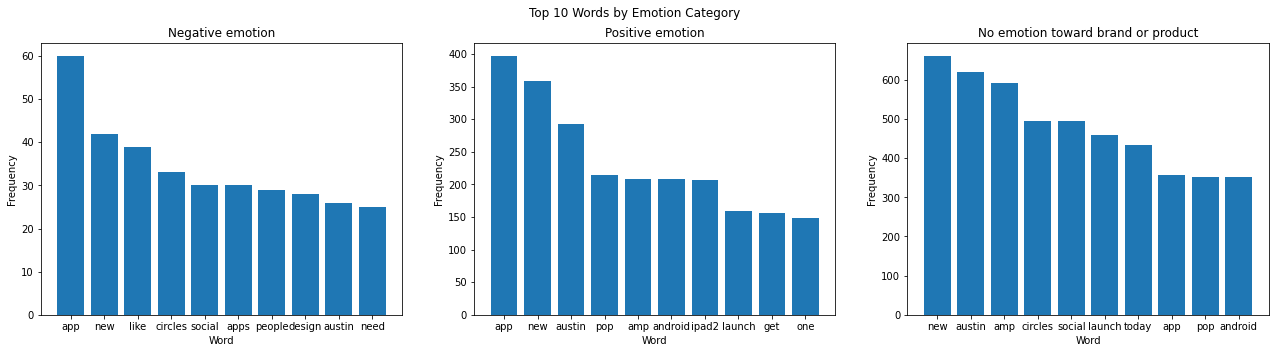

In [27]:
#Visualize token frequency by emotion with new stopwords
plot_frequency_by_emotion(df)

This is useful for me, but perhaps less useful as a visualization for a stakeholder, so let's make one with a few less terms. 

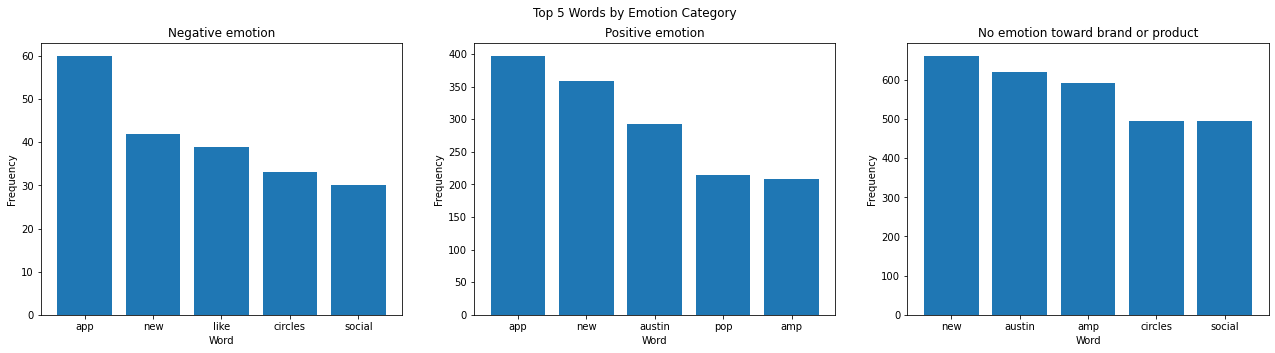

In [28]:
#Function to plot Top 5 tokens by emotion
def plot_frequency5_by_emotion(dataframe):
    # Tokenize words in the 'tweets_tokenized' column and creating a list of all tokens
    all_tokens = [token for tweet in df['tweets_tokenized'] for token in tweet]

    # Calculate frequency distribution for all tokens
    all_tokens_freq = FreqDist(all_tokens)

    # Set up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22,5))

    # Plot frequency distribution for each category
    for index, emotion in enumerate(df['emotion'].unique()):
        # Filter dataframe by emotion category and tokenizing words
        category_tokens = [token for tweet in df[df['emotion'] == emotion]['tweets_tokenized'] for token in tweet]

        # Calculate frequency distribution for this category
        category_tokens_freq = FreqDist(category_tokens)

        # Get top 3 most common tokens and their counts
        top_5_tokens = [token[0] for token in category_tokens_freq.most_common(5)]
        top_5_counts = [token[1] for token in category_tokens_freq.most_common(5)]

        # Plot bar chart of top 10 tokens and their counts
        ax = axes[index]
        ax.bar(top_5_tokens, top_5_counts)
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    plt.suptitle('Top 5 Words by Emotion Category')
    plt.show()

plot_frequency5_by_emotion(df)

Ok, that removed much of our original top 10, but it looks like there is still some significant overlap.  The words app, new, and austin are in three of the top 10, while social, amp, circles, launch, pop, and android are in two.  Let's move ahead and see how this first change affects the accuracy of our model. 

In [29]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Instantiate a MultinomialNB classifier
second_model = MultinomialNB()

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

In [30]:
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(second_model, X_train_vectorized, y_train)
stopwords_removed_cv

array([0.59803922, 0.61667835, 0.6152768 , 0.61387526, 0.60406447])

In [31]:
#Compare original model to new model
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.6036995597117614
Stopwords removed: 0.6095868200118169


The slightest improvement.  Rather than keep adding to the stopword list, let's see if stemming helps the model improve.

### Build a Third Model with Stemmer

In [32]:
#Stemmer variable
stemmer = SnowballStemmer(language="english")

#Stemmer function
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

I also need to stem the stopwords

In [33]:
#Stem stopwords
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [34]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Instantiate a MultinomialNB classifier
third_model = MultinomialNB()

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

In [35]:
# Evaluate the classifier on X_train_vectorized and y_train
stemmed_cv = cross_val_score(third_model, X_train_vectorized, y_train)
stemmed_cv

array([0.60084034, 0.61457603, 0.61247372, 0.60967064, 0.60546601])

In [36]:
#Compare best model with stemmer addition
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.6095868200118169
Stemmed:           0.6086053482360008


An ever so slightly worse model. So the best model so far is removing the stop words (with the additional stop words appended).

### Pause in Modeling- Data Exploration

Now that we have started stemming, let's make another column with the stemmed words and explore what we find.  The analysis of the data from the tweets would be the next step after using the model to correctly predict and categorize the emotion class of new data, so let's see what this current data can tells us as a preview for future applications of our final model. 

In [37]:
# define a function to apply the stemmer to each word in a list
def stem_words(words):
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

# apply the stem_words function to each list of words in the tweets_tokenized column
df['tweets_stemmed'] = df['tweets_tokenized'].apply(lambda x: stem_words(x))

In [38]:
df.head()

,tweets,products,emotion,tweets_tokenized,tweets_stemmed
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, 3g, hrs, tweeting, rise_austin, dea...","[wesley83, 3g, hrs, tweet, rise_austin, dead, ..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, app, likely...","[jessede, know, fludapp, awesom, app, like, ap..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, app]","[hope, year, festiv, crashi, year, app]"
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,..."


Now that we have the tokens stemmed in a column, let's redo our function for plotting the frequency of terms with this new tweets_stemmed column and see how that changes the results. 

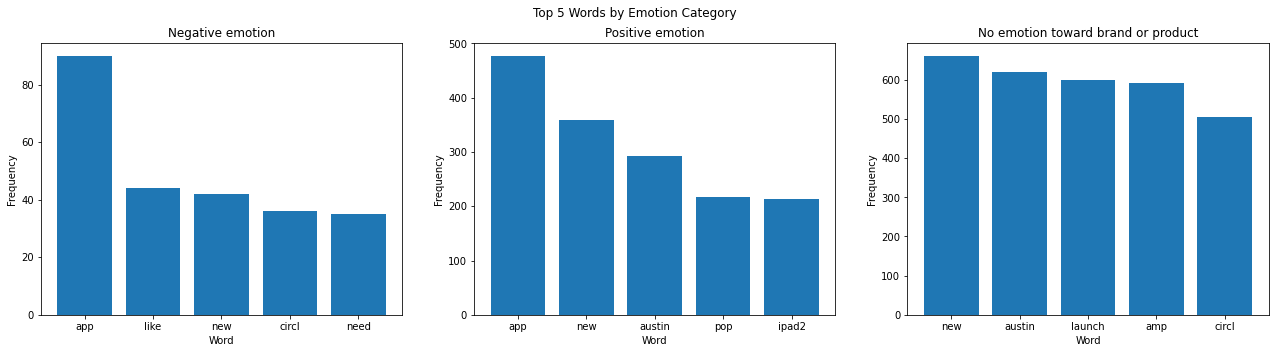

In [39]:
#Function to plot Top 5 tokens by emotion
def plot_frequency5_by_emotion(dataframe):
    # Tokenize words in the 'tweets_tokenized' column and creating a list of all tokens
    all_tokens = [token for tweet in df['tweets_stemmed'] for token in tweet]

    # Calculate frequency distribution for all tokens
    all_tokens_freq = FreqDist(all_tokens)

    # Set up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22,5))

    # Plot frequency distribution for each category
    for index, emotion in enumerate(df['emotion'].unique()):
        # Filter dataframe by emotion category and tokenizing words
        category_tokens = [token for tweet in df[df['emotion'] == emotion]['tweets_stemmed'] for token in tweet]

        # Calculate frequency distribution for this category
        category_tokens_freq = FreqDist(category_tokens)

        # Get top 3 most common tokens and their counts
        top_5_tokens = [token[0] for token in category_tokens_freq.most_common(5)]
        top_5_counts = [token[1] for token in category_tokens_freq.most_common(5)]

        # Plot bar chart of top 10 tokens and their counts
        ax = axes[index]
        ax.bar(top_5_tokens, top_5_counts)
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    plt.suptitle('Top 5 Words by Emotion Category')
    plt.show()

plot_frequency5_by_emotion(df)

Interesting.  The top five terms are different once the tokens have been stemmed.  This is the visualization we will use for the presentation to the stakeholders. 

Recall that the words app, new, austin, and pop are high frequency in two. So note especially iPad2 is a frequent word in the the postivively-labelled tweets that is unique to the positive emotion class and is a product rather than a random word, so this could be interesting to explore.  

Let's take a look at all the positive labeled tweets with the word iPad2 in them. Below is the most recent dataframe.

In [40]:
#Preview data
df.head()

,tweets,products,emotion,tweets_tokenized,tweets_stemmed
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, 3g, hrs, tweeting, rise_austin, dea...","[wesley83, 3g, hrs, tweet, rise_austin, dead, ..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, app, likely...","[jessede, know, fludapp, awesom, app, like, ap..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, app]","[hope, year, festiv, crashi, year, app]"
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,..."


Let's just look at the positive tweets that contained with word ipad2.

In [41]:
#Create new dataframe for positive tweets with ipad2 in them
ipad2_df = df[(df['emotion'] == 'Positive emotion') & (df['tweets_stemmed'].apply(lambda x: 'ipad2' in x))]
ipad2_df.head()

,tweets,products,emotion,tweets_tokenized,tweets_stemmed
19,need to buy an ipad2 while i'm in austin at #s...,iPad,Positive emotion,"[need, buy, ipad2, austin, sure, need, austin]","[need, buy, ipad2, austin, sure, need, austin]"
35,the best! rt @mention ha! first in line for #...,iPad,Positive emotion,"[best, ha, first, line, ipad2, pop, event, pla...","[best, ha, first, line, ipad2, pop, event, pla..."
39,@mention - great weather to greet you for #sx...,Apple,Positive emotion,"[great, weather, greet, still, need, sweater, ...","[great, weather, greet, still, need, sweater, ..."
44,#ipad2 's ۷#smartcover۪ opens to instant acces...,iPad or iPhone App,Positive emotion,"[ipad2, smartcover, opens, instant, access, wa...","[ipad2, smartcov, open, instant, access, wait,..."
61,#omfg! rt @mention heard about apple's pop-up ...,Apple,Positive emotion,"[omfg, heard, pop, downtown, austin, pics, alr...","[omfg, heard, pop, downtown, austin, pic, alre..."


Great, now we only have the positive tweets with the word ipad2 in it.  Let's create a visualization of the top words in these ipad2 tweets to narrow our focus.

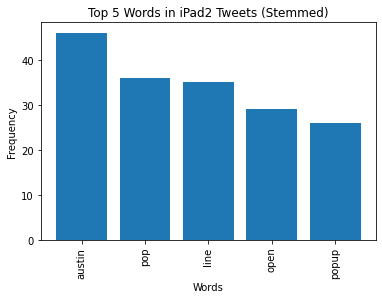

In [42]:
ipad2_df = ipad2_df.copy()

# join the lists of stemmed words into a single string
ipad2_df['tweets_combined'] = ipad2_df['tweets_stemmed'].apply(lambda x: ' '.join(x))

# create a CountVectorizer object
vectorizer = CountVectorizer(stop_words=['ipad2'])

# fit and transform the 'tweets_combined' column
X = vectorizer.fit_transform(ipad2_df['tweets_combined'])

# sum the counts across all tweets and sort the resulting array in descending order
word_counts = X.sum(axis=0).tolist()[0]
words = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]
word_counts, words = zip(*sorted(zip(word_counts, words), reverse=True))

# create a bar chart of the top 5 words
plt.bar(words[:5], word_counts[:5])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Words in iPad2 Tweets (Stemmed)')
plt.show()

Great. Recall that the words austin and pop are high frequency terms in the other thee emotion classes. Outside of these terms,  the term "line" is the highest frequency, so let's take a look at the kinds of tweets that contain it (along with stem ipad2, of course)

In [43]:
# filter the rows that contain the word 'white' in the 'tweets_stemmed' column
line_df = ipad2_df[ipad2_df['tweets_stemmed'].apply(lambda x: any(['line' in word for word in x]))]

# set the maximum column width to 1000 to see the entire tweet
pd.options.display.max_colwidth = 1000

# view the first five rows of the 'tweets' column of the 'white_tweets' dataframe
line_df['tweets']

35      the best!  rt @mention ha! first in line for #ipad2 at #sxsw &quot;pop-up&quot; apple store was an event planner #eventprofs #pcma #engage365
185                                      it's like 10pm at night and there is a line around the block at the popup apple stores selling ipad2s. #sxsw
304                         temporary apple store will be a block from my office! can't wait to see the line tomorrow. photos to come... #sxsw #ipad2
349                               hey #sxsw attendees...you should hop in line at the #apple store now. only four days til your new ipad2 comes in...
632                                      i've been having meetings while i'm in line at the #sxsw popup apple store for the ipad2. i love this place!
1009                                                                         nice line outside #sxsw #apple store! i guess people want some ipad2s!!!
1037                                                                     the apple pop-up store line

Interesting!  A cursory glance suggests that most of these tweets are about waiting in line and/or the size of the line to acquire the ipad2.  Customers are talking about the lines for the ipad2 in a positive way, and so not only does queuing up for a new release seem to generate positive publicity concerning the product itself, but also tracking tweets with the term "line" may help Google track the positive zeitgeist surrounding the release of a product.  

For the purposes of this project, we will assume these have all been correctly labeled as "Positive emtion," but there are several tweets where this label seems inaccurate.  Several tweets that mention the length of the line leave it ambiguous as to whether their tweet is meant to be a negative or positive comment. For example, take the following tweets:

**ipad2 takes over #sxsw. the line was already halfway down the block around noon. craziness**

**days later there's still a line out the door at the #sxsw apple store for the ipad2.**

These do not necessarily read as positive tweets to me. 

Another tweet states: 

**the line for the apple popup store at #sxsw stretches around the block...guess i won't be getting the ipad2**

This would seem to me to be a negative tweet.

This was a informative avenue of exploration. A comprehensive analsysis of this sort does not fit the scope of this project, but let's look at these tweets in one other way to see if it produces anything fruitful.  Let's look at the top 3 products for each emotion class. 

In [44]:
def plot_top_products(df, emotion):
    # Group the dataframe by products and emotion columns to count the number of tweets for each product-emotion combination
    count_df = df[df['emotion'] == emotion].groupby(['products']).size().reset_index(name='counts')
    
    # Get the top 3 products with the most tweets of the given emotion
    top_products = count_df.nlargest(3, 'counts')
    
    # Plot the bar chart
    plt.bar(top_products['products'], top_products['counts'])
    plt.title(f'Top 3 products with the most {emotion.lower()} tweets')
    plt.xlabel('Products')
    plt.ylabel('Number of tweets')
    plt.show()

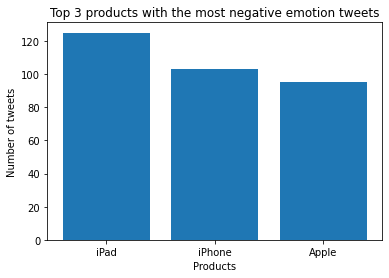

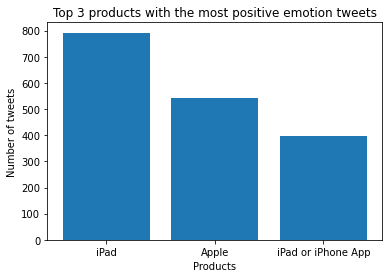

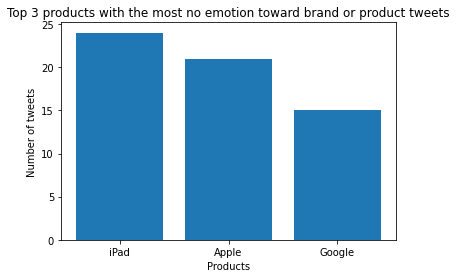

In [45]:
# Plot the top 3 products with the most negative tweets
plot_top_products(df, 'Negative emotion')

# Plot the top 3 products with the most positive tweets
plot_top_products(df, 'Positive emotion')

# Plot the top 3 products with the most no emotion tweets
plot_top_products(df, 'No emotion toward brand or product')

Also interesting.  The iPad is number 1 in all three Emotion Classes, and the product label Apple is found in all three Emotion Classes as well.  Let's take a look at the top words for each of these products in each of these emotion classes.

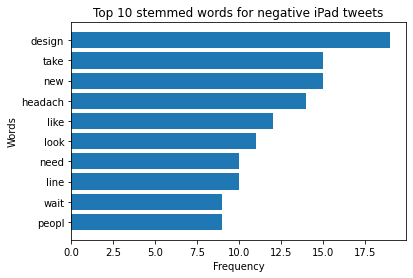

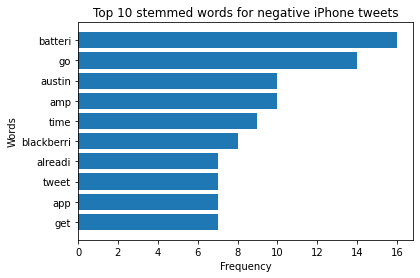

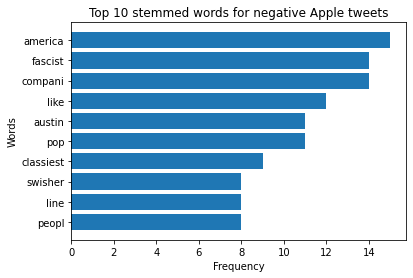

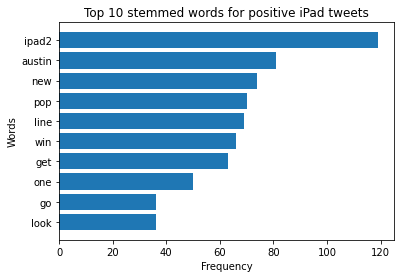

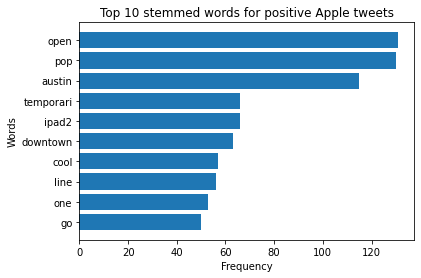

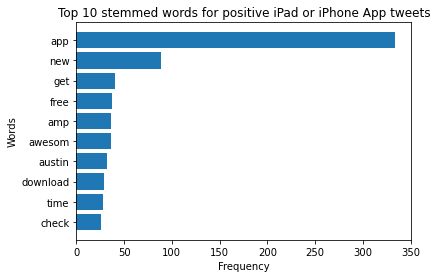

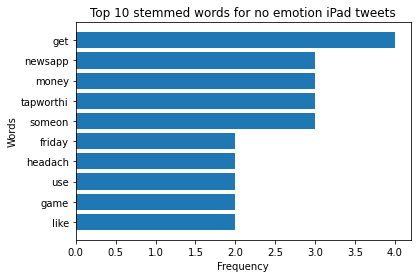

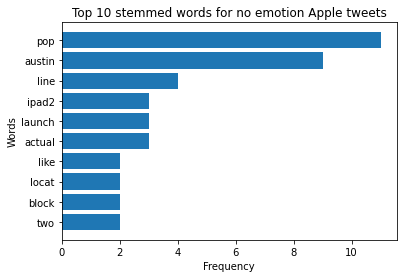

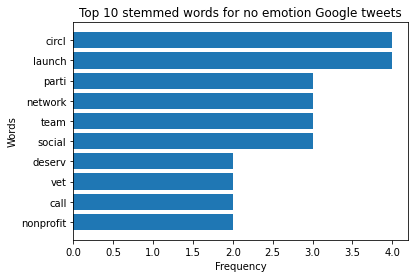

In [46]:
# Create a dictionary to map emotion codes to emotion labels
emotion_map = {
    'Negative emotion': 'negative',
    'Positive emotion': 'positive',
    'No emotion toward brand or product': 'no emotion'
}

# Define a function to get the top 10 stemmed words for a given product and emotion
def get_top_words(df, product, emotion):
    # Filter the dataframe to include only the given product and emotion
    filtered_df = df[(df['products'] == product) & (df['emotion'] == emotion)]
    # Concatenate all the stemmed words into a list
    all_words = [word for tweet in filtered_df['tweets_stemmed'] for word in tweet]
    # Count the frequency of each word
    word_counts = pd.Series(all_words).value_counts()
    # Get the top 10 words
    top_words = word_counts.iloc[:10]
    return top_words

# Define a function to plot a bar chart for the top 10 stemmed words for a given product and emotion
def plot_bar_chart(df, product, emotion):
    # Get the top 10 stemmed words for the given product and emotion
    top_words = get_top_words(df, product, emotion)
    # Plot the bar chart
    plt.barh(top_words.index, top_words.values)
    plt.gca().invert_yaxis()
    plt.title(f'Top 10 stemmed words for {emotion_map[emotion]} {product} tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Call the plot_bar_chart function for each emotion and each of the top 3 products
for emotion in emotion_map.keys():
    top_products = df[df['emotion'] == emotion]['products'].value_counts().nlargest(3).index.tolist()
    for product in top_products:
        plot_bar_chart(df, product, emotion)

Let's stick with the iPad for now and focus on the positive and negative word clouds, which may be more interesting to a stakeholder.  We see that iPad2 is large and present in the Top 10 words of the positive iPad tweets, as we already knew, but we also see iPad2 in the Top 10 words of the negative iPad tweets (though a smaller size).  The largest word in the negative iPad tweets looks like "design."    

Let's take a look at the iPad tweets in the negative emotion class that contain the word "design."  

In [47]:
#Create new dataframe for positive tweets with ipad2 in them
ipad2_df2 = df[(df['emotion'] == 'Negative emotion') & (df['products'] == 'iPad') & (df['tweets_stemmed'].apply(lambda x: 'design' in x))]
ipad2_df2.head()

,tweets,products,emotion,tweets_tokenized,tweets_stemmed
66,attending @mention ipad design headaches #sxsw {link},iPad,Negative emotion,"[attending, design, headaches]","[attend, design, headach]"
1788,at #sxsw #tapworthy ipad design headaches - avoiding the pitfalls of the new design challenges,iPad,Negative emotion,"[tapworthy, design, headaches, avoiding, pitfalls, new, design, challenges]","[tapworthi, design, headach, avoid, pitfal, new, design, challeng]"
1929,#sxsw: ipad design headaches (take two tablet and call me in the morning) {link},iPad,Negative emotion,"[design, headaches, take, two, tablet, call, morning]","[design, headach, take, two, tablet, call, morn]"
2841,getting ready for &quot;ipad design headaches&quot; #sxsw,iPad,Negative emotion,"[getting, ready, design, headaches]","[get, readi, design, headach]"
3120,"in ipad design headaches: take two tablets, call me in the am panel - excited to hear @mention live! #sxsw",iPad,Negative emotion,"[design, headaches, take, two, tablets, call, panel, excited, hear, live]","[design, headach, take, two, tablet, call, panel, excit, hear, live]"


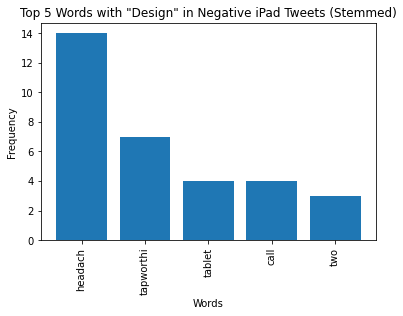

In [48]:
# join the lists of stemmed words into a single string
ipad2_df2 = ipad2_df2.copy()
ipad2_df2['tweets_combined'] = ipad2_df2['tweets_stemmed'].apply(lambda x: ' '.join(x))

# create a CountVectorizer object
vectorizer = CountVectorizer(stop_words=['design'])

# fit and transform the 'tweets_combined' column
X = vectorizer.fit_transform(ipad2_df2['tweets_combined'])

# sum the counts across all tweets and sort the resulting array in descending order
word_counts = X.sum(axis=0).tolist()[0]
words = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]
word_counts, words = zip(*sorted(zip(word_counts, words), reverse=True))

# create a bar chart of the top 15 words
plt.bar(words[:5], word_counts[:5])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Words with "Design" in Negative iPad Tweets (Stemmed)')
plt.show()

It looks like we're getting a warning because of the symbol in front of the word "button."  Since there is only one instance of this word in this visualization of the top terms with "design," let's ignore that for now and focus on the most common stem, "headach."  Future iterations of this project may want to loop through the stemmed words to double-check if there are any other special characters elsewhere in the tweets_stemmed column.  

In [49]:
# filter the rows that contain the word 'white' in the 'tweets_stemmed' column
wait_df = ipad2_df2[ipad2_df2['tweets_stemmed'].apply(lambda x: any(['headach' in word for word in x]))]

# set the maximum column width to 1000 to see the entire tweet
pd.options.display.max_colwidth = 1000

# view the first five rows of the 'tweets' column of the 'white_tweets' dataframe
wait_df['tweets']

66                                                                                     attending @mention ipad design headaches #sxsw {link}
1788                                          at #sxsw #tapworthy ipad design headaches - avoiding the pitfalls of the new design challenges
1929                                                        #sxsw: ipad design headaches (take two tablet and call me in the morning) {link}
2841                                                                               getting ready for &quot;ipad design headaches&quot; #sxsw
3120                              in ipad design headaches: take two tablets, call me in the am panel - excited to hear @mention live! #sxsw
3224                                                                             kicking off w/ @mention talking ipad design headaches #sxsw
3376      ipad design headaches. interface metaphor. looks like a book, make it behave like a book. simple stuff, but often forgotten. #sxsw
4063         

Perhaps surprisingly, this looks like the name of a talk given at South by Southwest, and perhaps has been mislabeled negatively, as most of these tweets are simply posting about their attendance at the talk itself.  Some even express their interest in the talk.  

This calls into question the data itself, as these tweets shouldn't be labeled as expressing negative emotions.  

###Build Fourth Model with Best TF-IDF max_features 

Let's resume modeling and assume we have accurately-labeled data. Right now I am only allowing the model to look at the tf-idf of the top 10 most frequent tokens. If I allow it to look at all possible tokens, that could lead to high dimensionality issues, but let's take a look at how long our X_train is and figure out what we could change our max_features to. 

In [50]:
#Check length of X_train
len(X_train)

7136

Setting max_features to 7136 would mean an equal number of rows and columns, something that can cause problems for many model algorithms.

I will try increasing max_features from 10 to 200.  Since I will be iterating more models, I will build a function to make the process a little less repetetive.

In [51]:
#Model function
def model(maximum_features):
  tfidf = TfidfVectorizer(
      max_features=maximum_features,
      stop_words=stemmed_stopwords,
      tokenizer=stem_and_tokenize,
      token_pattern=None
)
  # Initialize the Naive Bayes classifier
  fourth_model = MultinomialNB()

  #Transform the training data into feature vectors
  X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

  # Calculate the cross-validation score
  cv_score = cross_val_score(fourth_model, X_train_vectorized, y_train)
  return cv_score

In [52]:
#Create model with 200 max_features for TF-IDF
model_200 = model(200)
model_200

array([0.65546218, 0.63980378, 0.63770147, 0.63910301, 0.63139453])

In [53]:
#Create model with 500 max_features for TF-IDF
model_500 = model(500)
model_500

array([0.67016807, 0.66012614, 0.66152768, 0.66222845, 0.64751226])

The model keeps getting better.  Rather than check every value for max_features, I will create a loop to figure it out the closest max_feature value.

In [54]:
# Define the range of maximum features to test
max_features_range = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Initialize an empty dictionary to store the cross-validation scores
cv_scores_dict = {}

# Iterate through each value of maximum features and calculate the cross-validation score
for max_features in max_features_range:
    # Initialize the TfidfVectorizer with the current value of maximum features
    tfidf = TfidfVectorizer(
        max_features=max_features,
        stop_words=stemmed_stopwords,
        tokenizer=stem_and_tokenize,
        token_pattern=None
    )

    # Initialize the Naive Bayes classifier
    fourth_model = MultinomialNB()

    # Transform the training data into feature vectors
    X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

    # Calculate the cross-validation score
    cv_score = np.mean(cross_val_score(fourth_model, X_train_vectorized, y_train, cv=5))

    # Store the cross-validation score in the dictionary
    cv_scores_dict[max_features] = cv_score

# Print the dictionary of cross-validation scores
print(cv_scores_dict)

# Find the maximum cross-validation score and the corresponding value of maximum features
max_cv_score = max(cv_scores_dict.values())
best_max_features = [k for k, v in cv_scores_dict.items() if v == max_cv_score][0]

# Print the best value of maximum features and the corresponding cross-validation score
print("Best maximum features:", best_max_features)
print("Cross-validation score:", max_cv_score)

{500: 0.6603125202428554, 1000: 0.6589119600187657, 1500: 0.6618543142554849, 2000: 0.6618551975800832, 2500: 0.6625558702808384, 3000: 0.6624159124056069, 3500: 0.6600335859641684, 4000: 0.6611541322906177}
Best maximum features: 2500
Cross-validation score: 0.6625558702808384


Great, so our final model will have a max_features value of 2500.

In [55]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=2500,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    token_pattern=None
)

# Instantiate the MultinomialNB model
final_NB_model = MultinomialNB()

#Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])
final_NB_model.fit(X_train_vectorized, y_train)

# Transform the test data using the vectorizer
X_test_vectorized = tfidf.transform(X_test["tweets"])

# Predict the labels for the test data
y_pred = final_NB_model.predict(X_test_vectorized)

# Calculate the metrics
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

# Evaluate the classifier on X_train_vectorized and y_train
final_cv = cross_val_score(final_NB_model, X_train_vectorized, y_train)
print("Final CV score:", final_cv)

Precision: 0.75
Accuracy: 0.67
Recall: 0.46
F1 score: 0.47
Final CV score: [0.66386555 0.66783462 0.67203924 0.66012614 0.64891381]


Ok, so we have acceptable precision and accuracy scores. Accuracy can be misleading in the case of imbalanced datasets, like ours, so it probably isn't the main metric we will use.  The high precision suggests the model is ok at avoiding false positives.  Recall and the related F1 score are a little low, so this model isn't as good at labeling all postive samples for each class.  

The cv is better indicator for new, unseen data.  Recall that simply guessing based on the plurality would result in a 60.37% cv score, so this model with a cv score of 66.39% is only slightly better than random guessing.

Let's plot confusion matrix to visualize what this model does.

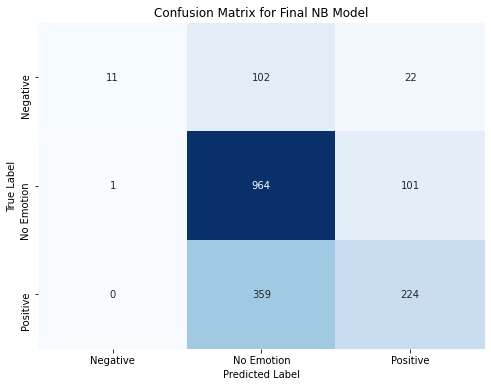

In [56]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the new labels
labels = ['Negative', 'No Emotion', 'Positive']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix for Final NB Model')

plt.show()

Let's consolidate that into a binary confusion matrix for the stakeholder presentation.

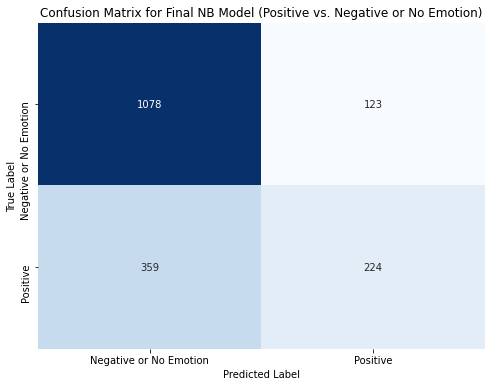

In [57]:
# Map the "Negative emotion" and "No emotion toward brand or product" classes to a single category
y_test_new = np.where(y_test == 'Positive emotion', 'Positive', 'Negative or No Emotion')
y_pred_new = np.where(y_pred == 'Positive emotion', 'Positive', 'Negative or No Emotion')

# Create the confusion matrix
cm = confusion_matrix(y_test_new, y_pred_new)

# Define the new labels
labels = ['Negative or No Emotion', 'Positive']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix for Final NB Model (Positive vs. Negative or No Emotion)')

plt.show()

This model does well to evaluate the Negative or No Emotion class.  It has a significant number of false negatives.  Just in case another type of model could prove better than this final Naive Bayes model, let's take a look at what some others models' baselines look like. 

In [58]:
df2 = df
df2.head()

,tweets,products,emotion,tweets_tokenized,tweets_stemmed
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative emotion,"[wesley83, 3g, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations]","[wesley83, 3g, hrs, tweet, rise_austin, dead, need, upgrad, plugin, station]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, app, likely, appreciate, design, also, giving, free, ts]","[jessede, know, fludapp, awesom, app, like, appreci, design, also, give, free, ts]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive emotion,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, app]","[hope, year, festiv, crashi, year, app]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


In [59]:
X = df2.drop(columns=['emotion']) #Collection of documents
y = df2['emotion'] # Target or the labels we want to predict (i.e., the 3 different emotion labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [60]:
# define a custom tokenizer to join lists of strings into a single string
def join_tokens(tokens_list):
    return ' '.join(tokens_list)


# extract features and labels
tfidf = TfidfVectorizer(tokenizer=join_tokens)
features = tfidf.fit_transform(df2['tweets_stemmed'].apply(join_tokens)).toarray()
labels = df2['emotion']

# define models
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5-fold cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [61]:
# Group the data by model name and compute the mean and standard deviation of the accuracy
results = cv_df.groupby('model_name').agg({'accuracy': ['mean', 'std']})

# Print the results
print(results)

                        accuracy          
                            mean       std
model_name                                
LinearSVC               0.607511  0.002581
LogisticRegression      0.605830  0.004941
MultinomialNB           0.602354  0.000307
RandomForestClassifier  0.606951  0.002923


And let's visualize this just for good measure.

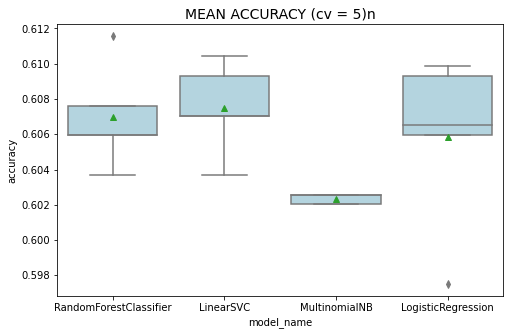

In [62]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

There doesn't seem to be that major difference between the models.  The LinearSVC is a few tenths of a percent better than the MultinomialNB, so perhaps we could try it out and see.  Let's add in a balanced class weight since we have an imbalanced dataset. 

In [63]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=2500,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    token_pattern=None
)

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary with the class weights
class_weight = dict(zip(np.unique(y_train), class_weights))

# Instantiate the LinearSVC model with class weights
final_SVC_model = LinearSVC(class_weight=class_weight)

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweets'])

# Train the model on the training data
final_SVC_model.fit(X_train_vectorized, y_train)

# Transform the test data using the vectorizer
X_test_vectorized = tfidf.transform(X_test['tweets'])

# Predict the labels for the test data
y_pred = final_SVC_model.predict(X_test_vectorized)

# Calculate the metrics
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

# Evaluate the classifier on X_train_vectorized and y_train
final_cv = cross_val_score(final_SVC_model, X_train_vectorized, y_train)
print("Final CV score:", final_cv)


Precision: 0.55
Accuracy: 0.65
Recall: 0.59
F1 score: 0.56
Final CV score: [0.64872945 0.66068759 0.66442451 0.64723468 0.6554559 ]


Recall that the MultinomialNB model produced the following metrics: 

Precision: 0.75

Accuracy: 0.67

Recall: 0.46

F1 score: 0.47

Final CV score: [0.66386555 0.66783462 0.67203924 0.66012614 0.64891381]

So this model has decreased precision and a slight descrease in the CV score, but increased recall and F1 score. 

If Google wants to prioritize precision, the final MultinomialNB model with precision of 0.75 is better, which means it correctly identifies more true positives and has fewer false positives.

If Google wants to prioritize recall, the LinearSVC model with recall of 0.59 is better, which means it correctly identifies more true positives and has fewer false negatives.

The F1 score, which balances both precision and recall, is also better in the LinearSVC model.

Finally, the MultinomialNB model has slightly better performance with a higher accuracy and mean CV score, but the difference is not very significant. 

Let's plot the confusion matrix for this SVC model so we can see how it compares to the NB model. 

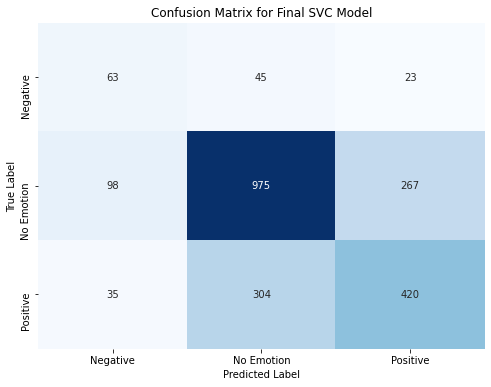

In [64]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the new labels
labels = ['Negative', 'No Emotion', 'Positive']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix for Final SVC Model')

plt.show()

Again, let's consolidate that confusion matrix for the stakholder presentation. 

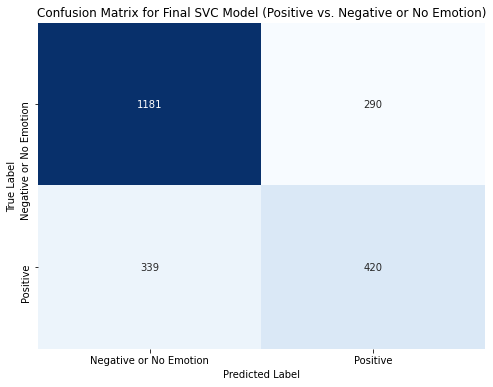

In [65]:
# Map the "Negative emotion" and "No emotion toward brand or product" classes to a single category
y_test_new = np.where(y_test == 'Positive emotion', 'Positive', 'Negative or No Emotion')
y_pred_new = np.where(y_pred == 'Positive emotion', 'Positive', 'Negative or No Emotion')

# Create the confusion matrix
cm = confusion_matrix(y_test_new, y_pred_new)

# Define the new labels
labels = ['Negative or No Emotion', 'Positive']

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix for Final SVC Model (Positive vs. Negative or No Emotion)')

plt.show()

It looks like the model is best at intepreting tweets with No Emotion.   This SVC model has more true positives and true negatives than the NB model.  The NB model has less false positives and both have comparable false negatives.  In terms of specific numbers the NB model has 123 False Positives and 224 True Positives, while the SVC model has 290 False Positives and 420 True Positives.  So the SVC model has 107 more False positives, but it also has 196 more True Positives.  Since the SVC model performs better in the 3 out of the 4 categories of this confusion matrix, we will stick with the SVC model as our final model.  

## Conclusion and Recommendations

This final model interprets tweets with no emotion relatively accurately. This is the plurality of the dataset. 

If Google is interested in an accurate model that will correctly predict a negative, positive, or emotionless tweet, further iterations with the current dataset could prove fruitful. 

There is still a high level of overlap between the top 10 tokens of the three classes.  Further removal of these overlapping tokens may help the model better distinguish between the three classes.

Beyond this dataset, a higher sample of positive and negative tweets could help the model in its predictive accuracy.  The vast majority of tweets in this dataset were labeled as containing no emotion.  If Google is interested in positive or negative tweets, this dataset could be extended with more relevant information.  

As for the analysis of the data itself, I have presented two methods of narrowing down the most popular terminology in the positve and negative tweets.  Investigating certain high frequency terms in the positive category, such as the terms "ipad2" and "line," may help Google track the positive zeitgeist surrounding the release of a product, which in turn may inform further product development.  In this case, queues to purchase the iPad2 resulted in positive Twitter discourse on the release of the product.  

Investigating certain high frequency terms in the negative category could prove similarly fruitful, if the labels of postiive and negative are accurate.  Unfortunately, investigating the stems "design" and "headach" demonstrated the inaccuracies of the baseline dataset.  Therefore, any further models on this dataset should cease until the accuracy of the is_there_an_emotion_directed_at_a_brand_or_product feature is verified.  


**In summary:**

This model provides a adequate baseline for classifying emotionless tweets. For further developement, high frequency terms that overlap across the three classes (positive, negative, no emotion) could be removed from the dataset while additional positively and negatively-labeled tweets should be introduced to the dataset.  Moreover, the is_there_an_emotion_directed_at_a_brand_or_product column of the initial dataset needs to be edited and re-labeled accurately for any supervised learning model to function effectively.  

Once this overlap is reduced, the additional data is included, and the current data is correcly labeled, the implementation of a similar model on new data can begin. An analysis of the new data's tokens and the corresponding information in each of the three classes will provide Google keen insights for future product development, as demonstrated.    